### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar100 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 4

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [2]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [3]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [4]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [5]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [6]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [7]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",
        "#d62728",
        "#ff7f0e",
        "#2ca02c",
    ]

    markers = ["--o", "-s", "-^", "-x"]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(20, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                markers[j],
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=24)
            if i == 0: axes[i].legend(prop={"size": 16}, loc="upper right")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 81, 10)))

    fig.supxlabel("Task Trained On", fontsize=24)
    fig.supylabel("Accuracy (%)\n", fontsize=24)
    plt.tight_layout()
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

CIFAR100 10 Tasks, 10 Classes Per Task

# ER

## Buffer 500

### Without Drift

In [8]:
# er_500_accuracy_array_without_drift = read_results(
#     "./logs/01-21-25-21-18-05-seq-cifar100-er-buf-500-drift-6-n-4-adaptation-0.json"
# )
# # 9.66, 9.78, 9.87
# # 9.769999999999998 ± 0.08602325267042588
# # plot_results(
# #     er_500_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_500_accuracy_array_without_drift)[1]

In [9]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-21-25-21-18-05-seq-cifar100-er-buf-500-drift-6-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-21-25-21-18-05-seq-cifar100-er-buf-500-drift-6-n-4-adaptation-0.json
FAA: 9.78 ± 0.00
Avg. Forgetting: 74.18 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9

In [10]:
# er_500_accuracy_array_with_drift = read_results(
#     "./logs/01-21-25-23-24-50-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-0.json"
# )
# # 8.62, 8.70, 8.79
# # 8.703333333333333 ± 0.0694422221866655
# # plot_results(
# #     er_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# # )
# average_forgetting(er_500_accuracy_array_with_drift)[1]

In [11]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-21-25-23-24-50-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-21-25-23-24-50-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-0.json
FAA: 8.70 ± 0.00
Avg. Forgetting: 75.58 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [12]:
# before reimplementation
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-00-09-31-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-1.json"
# )
# # 16.18, 16.31, 16.43
# # 16.306666666666665 ± 0.10208928554075702

In [13]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json"
# )
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-24-25-16-36-02-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json"
# )
# # 13.31, 13.86, 13.95
# plot_results(
#     er_500_accuracy_array_with_drift_full_relearning,
#     title="ER with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=500)",
# )

In [14]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-15-49-18-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-16-36-02-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-15-03-02-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 13.71 ± 0.28
Avg. Forgetting: 66.74 ± 0.46


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [15]:
# before reimplementation
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-02-07-26-seq-cifar100-er-buf-500-drift-5-n-4-adaptation-2.json"
# )
# # 11.67, 11.90, 12.37
# # 11.979999999999999 ± 0.29131884021921145

In [16]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json"
# )
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-18-09-10-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json"
# )
# # 12.47, 12.78, 13.12
# plot_results(
#     er_500_accuracy_array_with_drift_buffer_resampling,
#     title="ER with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=500)",
# )

In [17]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-17-38-36-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-24-25-17-06-22-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-18-09-10-seq-cifar100-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 12.79 ± 0.27
Avg. Forgetting: 69.96 ± 0.42


### Cumulative Plots

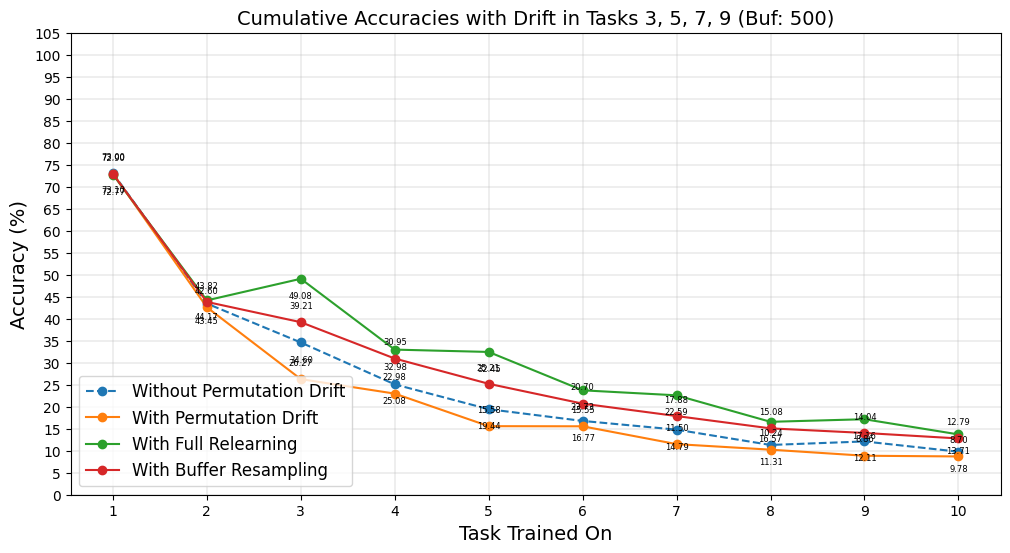

In [18]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [19]:
# er_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-22-25-03-53-38-seq-cifar100-er-buf-5000-drift-6-n-4-adaptation-0.json"
# )
# # 22.44, 22.80, 23.39
# # 22.876666666666665 ± 0.39160637833870293
# # plot_results(
# #     er_5000_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_5000_accuracy_array_without_drift)[1]

In [20]:
er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-22-25-03-53-38-seq-cifar100-er-buf-5000-drift-6-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-22-25-03-53-38-seq-cifar100-er-buf-5000-drift-6-n-4-adaptation-0.json
FAA: 22.80 ± 0.00
Avg. Forgetting: 56.51 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9

In [21]:
# er_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-22-25-05-12-56-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-0.json"
# )
# # 10.77, 11.01, 11.10
# # 10.96 ± 0.13928388277184126
# # plot_results(
# #     er_5000_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# # )
# average_forgetting(er_5000_accuracy_array_with_drift)[1]

In [22]:
er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-22-25-05-12-56-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-22-25-05-12-56-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-0.json
FAA: 11.01 ± 0.00
Avg. Forgetting: 69.67 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [23]:
# before reimplementation
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-06-26-42-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-1.json"
# )
# # 25.37, 25.40, 26.01
# # 25.593333333333334 ± 0.2948822740612871

In [24]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
# )
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-24-25-16-00-22-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
# )
# # 21.75, 22.01, 22.38
# plot_results(
#     er_5000_accuracy_array_with_drift_full_relearning,
#     title="ER with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=5000)",
# )

In [25]:
er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-16-50-49-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-15-09-05-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-16-00-22-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 22.05 ± 0.26
Avg. Forgetting: 54.66 ± 0.47


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [26]:
# before reimplementation
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-09-03-09-seq-cifar100-er-buf-5000-drift-5-n-4-adaptation-2.json"
# )
# # 23.72, 23.78, 23.82
# # 23.77333333333333 ± 0.041096093353127174

In [27]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
# )
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-17-53-47-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
# )
# # 23.71, 24.06, 24.41
# plot_results(
#     er_5000_accuracy_array_with_drift_buffer_resampling,
#     title="ER with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=5000)",
# )

In [28]:
er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-18-26-11-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-24-25-17-22-05-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-17-53-47-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 24.06 ± 0.29
Avg. Forgetting: 55.40 ± 0.59


### Cumulative Plots

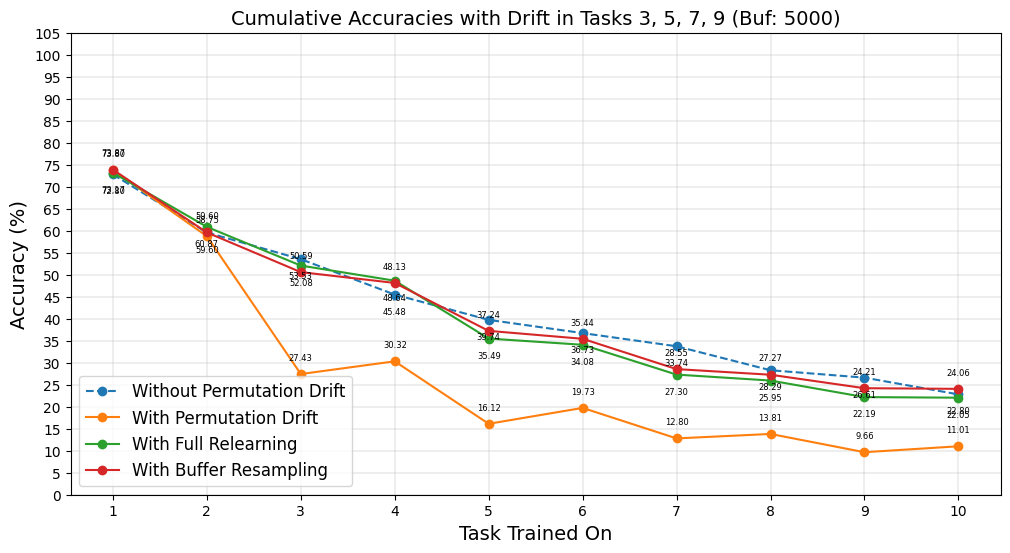

In [29]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Without Drift

In [30]:
# er_ace_500_accuracy_array_without_drift = read_results(
#     "./logs/01-21-25-23-30-03-seq-cifar100-er_ace-buf-500-drift-6-n-4-adaptation-0.json"
# )
# # 20.88, 21.82, 22.67
# # 21.790000000000003 ± 0.7310722718491437
# # plot_results(
# #     er_ace_500_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_ace_500_accuracy_array_without_drift)[1]

In [31]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-21-25-23-30-03-seq-cifar100-er_ace-buf-500-drift-6-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-21-25-23-30-03-seq-cifar100-er_ace-buf-500-drift-6-n-4-adaptation-0.json
FAA: 21.82 ± 0.00
Avg. Forgetting: 38.10 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9

In [32]:
# er_ace_500_accuracy_array_with_drift = read_results(
#     "./logs/01-22-25-00-12-08-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-0.json"
# )
# # 6.76, 6.86, 7.54
# # 7.053333333333334 ± 0.3465384378231207
# # plot_results(
# #     er_ace_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# # )
# average_forgetting(er_ace_500_accuracy_array_with_drift)[1]

In [33]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-22-25-00-12-08-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-22-25-00-12-08-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-0.json
FAA: 6.86 ± 0.00
Avg. Forgetting: 55.04 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [34]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-05-18-59-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-1.json"
# )
# # 17.43, 17.62, 17.95
# # 17.666666666666668 ± 0.21483844059095994

In [35]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json"
# )
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-24-25-16-52-53-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json"
# )
# # 15.60, 16.45, 16.66
# plot_results(
#     er_ace_500_accuracy_array_with_drift_full_relearning,
#     title="ER-ACE with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=500)",
# )

In [36]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-16-52-53-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-18-09-08-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-15-32-34-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 16.24 ± 0.46
Avg. Forgetting: 49.96 ± 0.57


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [37]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-07-36-40-seq-cifar100-er_ace-buf-500-drift-5-n-4-adaptation-2.json"
# )
# # 11.44, 12.29,  12.30
# # 12.01 ± 0.4030715403829286

In [38]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json"
# )
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-19-59-38-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json"
# )
# # 11.81, 11.81, 12.00
# plot_results(
#     er_ace_500_accuracy_array_with_drift_buffer_resampling,
#     title="ER-ACE with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=500)",
# )

In [39]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-19-59-38-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-24-25-20-56-17-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-19-03-32-seq-cifar100-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 11.87 ± 0.09
Avg. Forgetting: 51.70 ± 0.43


### Cumulative Plots

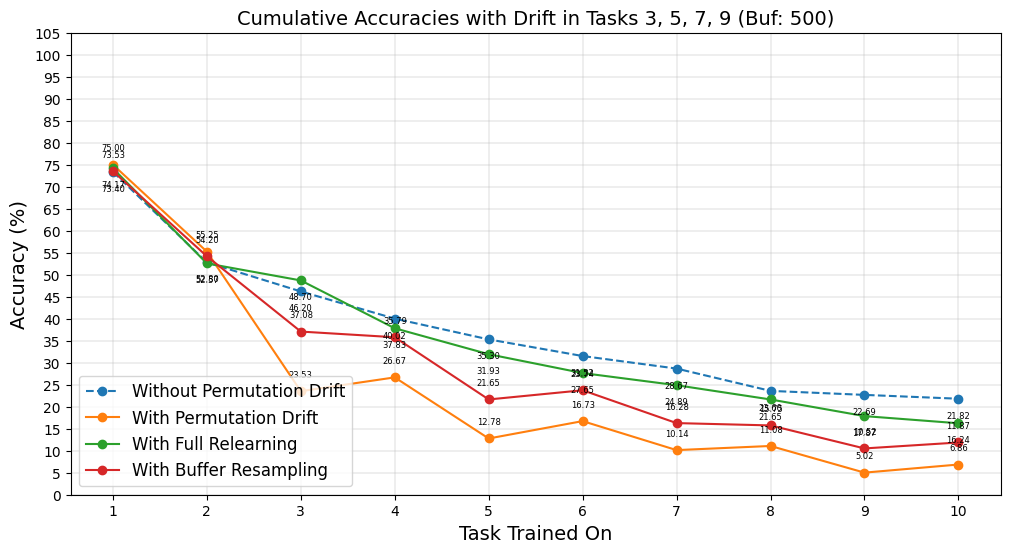

In [40]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [41]:
# er_ace_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-22-25-09-04-50-seq-cifar100-er_ace-buf-5000-drift-6-n-4-adaptation-0.json"
# )
# # 31.88, 32.03, 32.40
# # 32.10333333333333 ± 0.21853044537444974
# # plot_results(
# #     er_ace_5000_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_ace_5000_accuracy_array_without_drift)[1]

In [42]:
er_ace_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-22-25-09-04-50-seq-cifar100-er_ace-buf-5000-drift-6-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-22-25-09-04-50-seq-cifar100-er_ace-buf-5000-drift-6-n-4-adaptation-0.json
FAA: 32.03 ± 0.00
Avg. Forgetting: 31.83 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9

In [43]:
# er_ace_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-22-25-11-27-54-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-0.json"
# )
# # 9.66, 9.75, 9.99
# # 9.799999999999999 ± 0.13928388277184126
# # plot_results(
# #     er_ace_5000_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# # )
# average_forgetting(er_ace_5000_accuracy_array_with_drift)[1]

In [44]:
er_ace_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-22-25-11-27-54-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-22-25-11-27-54-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-0.json
FAA: 9.75 ± 0.00
Avg. Forgetting: 56.52 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [45]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-13-31-06-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-1.json"
# )
# # 25.24, 25.80, 25.89
# # 25.643333333333334 ± 0.28755675768253036

In [46]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
# )
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-24-25-17-08-53-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
# )
# # 22.68, 23.44, 23.88
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_full_relearning,
#     title="ER-ACE with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=5000)",
# )

In [47]:
er_ace_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-18-36-47-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-17-08-53-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-15-40-16-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 23.33 ± 0.50
Avg. Forgetting: 44.47 ± 0.67


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [48]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-18-33-45-seq-cifar100-er_ace-buf-5000-drift-5-n-4-adaptation-2.json"
# )
# # 21.94, 22.48, 22.78
# # 22.400000000000002 ± 0.3475629439396552

In [49]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
# )
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-20-28-30-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
# )
# # 22.11, 23.28, 23.38
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_buffer_resampling,
#     title="ER-ACE with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=5000)",
# )

In [50]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-20-28-30-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-24-25-19-33-42-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-21-26-39-seq-cifar100-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 22.92 ± 0.58
Avg. Forgetting: 46.73 ± 0.47


### Cumulative Plots

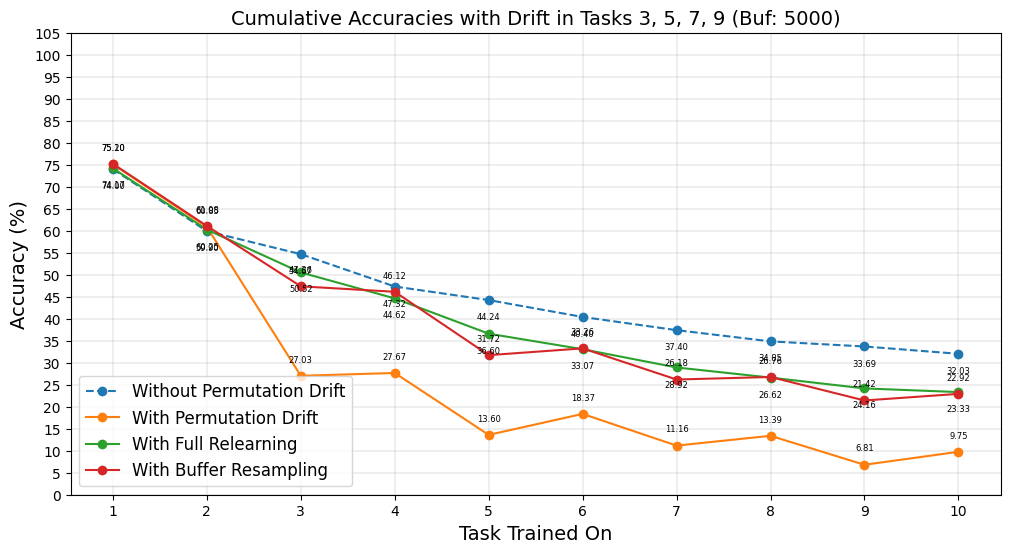

In [51]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# DER++

## Buffer 500

### Without Drift

In [52]:
# derpp_500_accuracy_array_without_drift = read_results(
#     "./logs/01-21-25-22-50-54-seq-cifar100-derpp-buf-500-drift-6-n-4-adaptation-0.json"
# )
# # 11.67, 11.76, 11.99
# # 11.806666666666667 ± 0.13474255287605172
# # plot_results(
# #     derpp_500_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(derpp_500_accuracy_array_without_drift)[1]

In [53]:
derpp_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-21-25-22-50-54-seq-cifar100-derpp-buf-500-drift-6-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-21-25-22-50-54-seq-cifar100-derpp-buf-500-drift-6-n-4-adaptation-0.json
FAA: 11.76 ± 0.00
Avg. Forgetting: 70.40 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9

In [54]:
# derpp_500_accuracy_array_with_drift = read_results(
#     "./logs/01-22-25-02-32-43-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-0.json"
# )
# # 8.85, 8.90, 8.94
# # 8.896666666666667 ± 0.036817870057290834
# # plot_results(
# #     derpp_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# # )
# average_forgetting(derpp_500_accuracy_array_with_drift)[1]

In [55]:
derpp_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-22-25-02-32-43-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-22-25-02-32-43-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-0.json
FAA: 8.90 ± 0.00
Avg. Forgetting: 74.33 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [56]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-22-25-06-54-49-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-1.json"
# )
# # 17.05, 17.05, 17.46
# # 17.186666666666667 ± 0.19327585352432305

In [57]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json"
# )
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-24-25-18-17-42-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json"
# )
# # 15.30, 16.44, 16.50
# plot_results(
#     derpp_500_accuracy_array_with_drift_full_relearning,
#     title="DER++ with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=500)",
# )

In [58]:
derpp_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-18-17-42-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-16-18-27-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-20-21-28-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 16.08 ± 0.55
Avg. Forgetting: 63.68 ± 0.63


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [59]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-22-25-14-40-25-seq-cifar100-derpp-buf-500-drift-5-n-4-adaptation-2.json"
# )
# # 11.42, 11.75, 11.85
# # 11.673333333333334 ± 0.18372685039360884

In [60]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json"
# )
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-21-44-08-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json"
# )
# # 11.78, 12.06, 12.21
# plot_results(
#     derpp_500_accuracy_array_with_drift_buffer_resampling,
#     title="DER++ with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=500)",
# )

In [61]:
derpp_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-21-44-08-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-25-25-00-30-05-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-23-06-51-seq-cifar100-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 12.02 ± 0.18
Avg. Forgetting: 68.91 ± 0.42


### Cumulative Plots

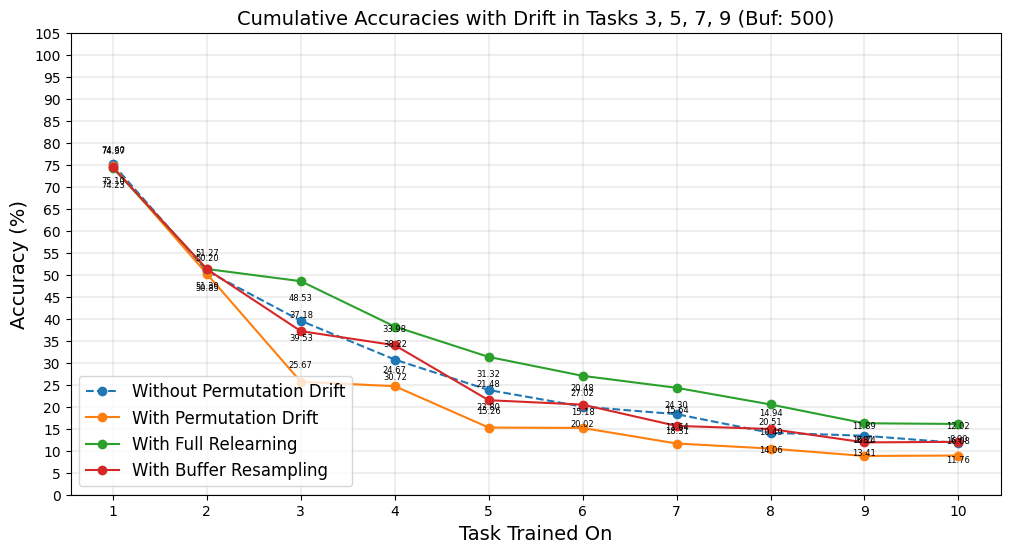

In [62]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [63]:
# derpp_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-22-25-15-56-23-seq-cifar100-derpp-buf-5000-drift-6-n-4-adaptation-0.json"
# )
# # 30.63, 31.30, 32.41
# # 31.44666666666667 ± 0.734045109119474
# # plot_results(
# #     derpp_5000_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(derpp_5000_accuracy_array_without_drift)[1]

In [64]:
derpp_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-22-25-15-56-23-seq-cifar100-derpp-buf-5000-drift-6-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-22-25-15-56-23-seq-cifar100-derpp-buf-5000-drift-6-n-4-adaptation-0.json
FAA: 31.30 ± 0.00
Avg. Forgetting: 35.58 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9

In [65]:
# derpp_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-22-25-21-31-28-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-0.json"
# )
# # 10.35, 10.39, 10.54
# # 10.426666666666668 ± 0.08178562764256828
# # plot_results(
# #     derpp_5000_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 3, 5, 7, 9",
# # )
# average_forgetting(derpp_5000_accuracy_array_with_drift)[1]

In [66]:
derpp_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-22-25-21-31-28-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-0.json"
)

1 files found
1: ./logs/01-22-25-21-31-28-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-0.json
FAA: 10.39 ± 0.00
Avg. Forgetting: 58.87 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [67]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-01-50-31-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-1.json"
# )
# # 27.79, 27.87, 28.44
# # 28.03333333333333 ± 0.28940552094864386

In [68]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
# )
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-24-25-18-43-43-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
# )
# # 24.32, 24.35, 24.57
# plot_results(
#     derpp_5000_accuracy_array_with_drift_full_relearning,
#     title="DER++ with Permutation Drift in Tasks 3, 5, 7, 9 and Full Relearning (buf=5000)",
# )

In [69]:
derpp_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-21-05-05-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/02-24-25-16-33-59-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/02-24-25-18-43-43-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 24.41 ± 0.11
Avg. Forgetting: 44.11 ± 0.53


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [70]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-07-52-45-seq-cifar100-derpp-buf-5000-drift-5-n-4-adaptation-2.json"
# )
# # 21.85, 22.32, 22.53
# # 22.233333333333334 ± 0.2842924941362717

In [71]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
# )
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-24-25-23-50-38-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
# )
# # 22.46, 22.53, 23.06
# plot_results(
#     derpp_5000_accuracy_array_with_drift_buffer_resampling,
#     title="DER++ with Permutation Drift in Tasks 3, 5, 7, 9 and Buffer Resampling (buf=5000)",
# )

In [72]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-24-25-23-50-38-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/02-25-25-01-16-20-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/02-24-25-22-26-58-seq-cifar100-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 22.68 ± 0.27
Avg. Forgetting: 54.97 ± 0.24


### Cumulative Plots

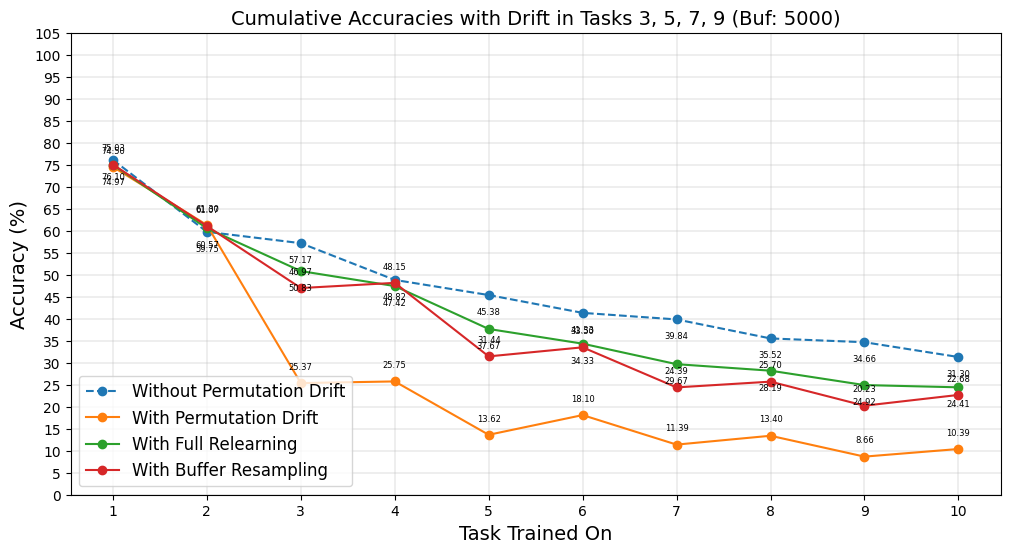

In [73]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# SER

## Buffer 500

### Without Drift

In [74]:
ser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-500-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-21-51-03-seq-cifar100-ser-buf-500-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-02-25-22-58-50-seq-cifar100-ser-buf-500-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-03-25-00-07-26-seq-cifar100-ser-buf-500-drift-6-s-5-n-4-adaptation-0.json
FAA: 26.91 ± 0.43
Avg. Forgetting: 41.73 ± 0.18


### With Permutation Drift in Tasks 3, 5, 7, 9

In [75]:
ser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-01-13-59-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-03-25-03-29-39-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-03-25-02-21-20-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-0.json
FAA: 12.29 ± 0.15
Avg. Forgetting: 58.29 ± 0.66


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [76]:
ser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-09-00-08-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/04-03-25-07-09-02-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/04-03-25-05-20-10-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 22.00 ± 0.48
Avg. Forgetting: 42.04 ± 0.64


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [77]:
ser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-10-11-39-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/04-03-25-11-23-19-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/04-03-25-12-34-28-seq-cifar100-ser-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 13.37 ± 0.18
Avg. Forgetting: 52.77 ± 0.32


### Cumulative Plots

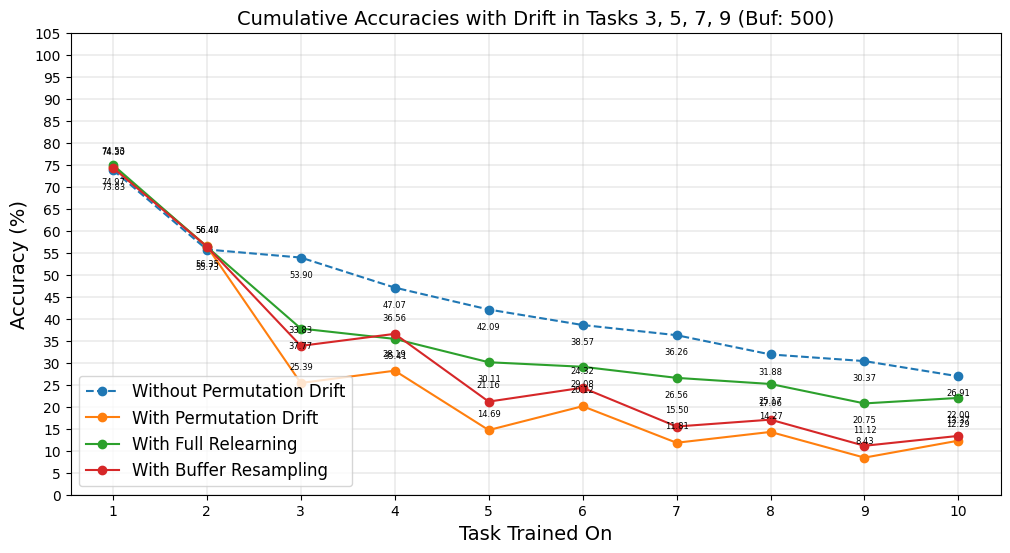

In [78]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [79]:
ser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-13-44-33-seq-cifar100-ser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-03-25-14-51-29-seq-cifar100-ser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-03-25-16-01-01-seq-cifar100-ser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 36.10 ± 0.15
Avg. Forgetting: 13.33 ± 0.58


### With Permutation Drift in Tasks 3, 5, 7, 9

In [80]:
ser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-18-17-50-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-03-25-19-25-34-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-03-25-17-08-49-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 10.96 ± 0.16
Avg. Forgetting: 42.29 ± 0.42


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [81]:
ser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-04-25-01-34-29-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/04-03-25-23-29-11-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/04-03-25-21-27-30-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 25.33 ± 0.38
Avg. Forgetting: 28.76 ± 0.70


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [82]:
ser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-04-25-03-58-12-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/04-04-25-05-09-44-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/04-04-25-02-45-27-seq-cifar100-ser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 20.88 ± 0.51
Avg. Forgetting: 46.44 ± 0.71


### Cumulative Plots

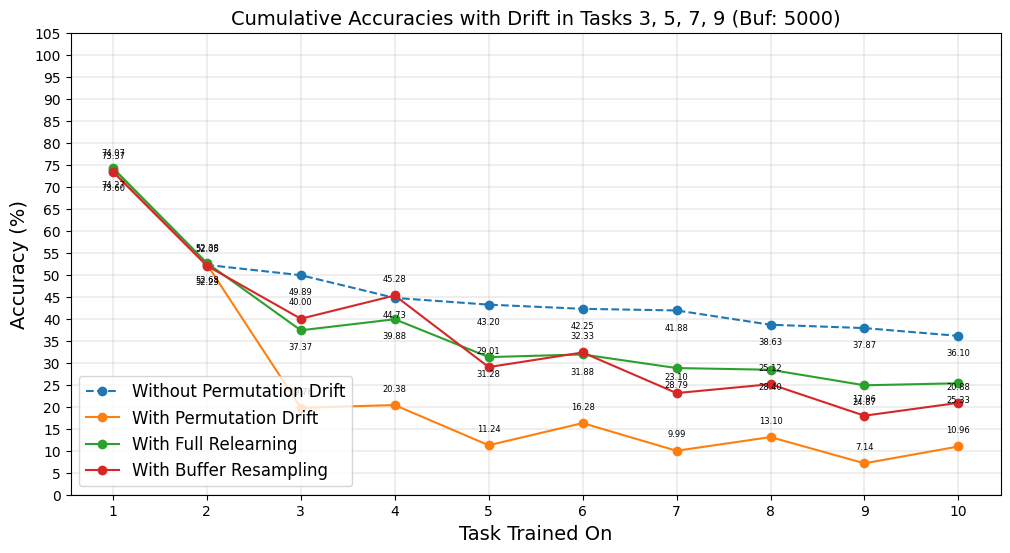

In [83]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# CLSER

## Buffer 500

### Without Drift

In [84]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-500-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-02-25-23-12-37-seq-cifar100-clser-buf-500-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-02-25-21-33-41-seq-cifar100-clser-buf-500-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-02-25-22-23-50-seq-cifar100-clser-buf-500-drift-6-s-5-n-4-adaptation-0.json
FAA: 11.77 ± 0.15
Avg. Forgetting: 73.05 ± 0.63


### With Permutation Drift in Tasks 3, 5, 7, 9

In [85]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-01-43-32-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-03-25-00-52-56-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-03-25-00-02-11-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-0.json
FAA: 9.38 ± 0.13
Avg. Forgetting: 76.09 ± 0.30


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [86]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-03-01-43-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/04-03-25-05-42-26-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/04-03-25-04-21-44-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 17.04 ± 0.16
Avg. Forgetting: 64.99 ± 0.44


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [87]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-07-29-24-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/04-03-25-08-24-12-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/04-03-25-06-35-50-seq-cifar100-clser-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 14.95 ± 0.31
Avg. Forgetting: 68.71 ± 0.69


### Cumulative Plots

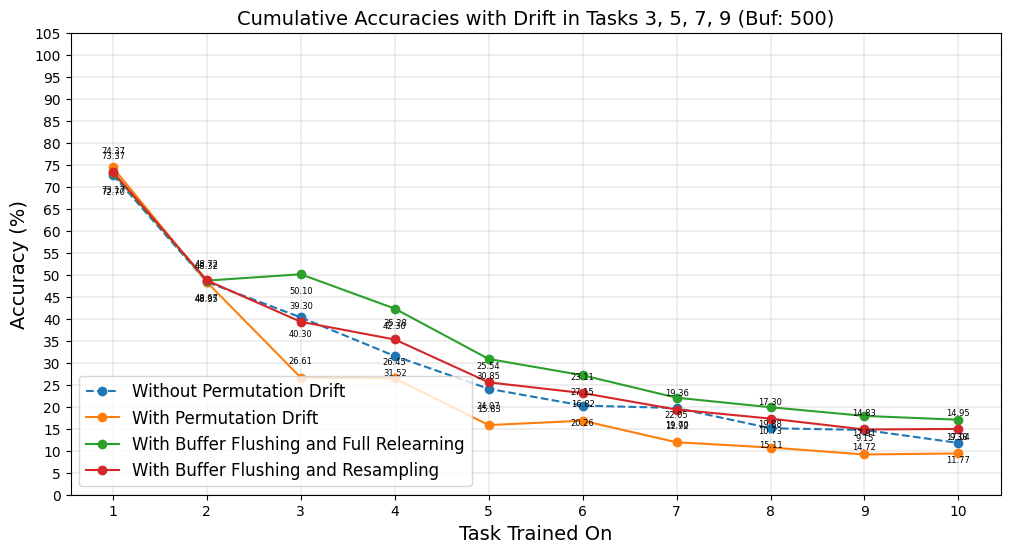

In [88]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [89]:
clser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-10-06-39-seq-cifar100-clser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-03-25-10-53-45-seq-cifar100-clser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-03-25-09-15-01-seq-cifar100-clser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 32.53 ± 0.48
Avg. Forgetting: 42.83 ± 0.50


### With Permutation Drift in Tasks 3, 5, 7, 9

In [90]:
clser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-11-45-55-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-03-25-13-28-39-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-03-25-12-37-58-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 12.83 ± 0.19
Avg. Forgetting: 64.49 ± 0.14


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [91]:
clser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-17-59-50-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/04-03-25-16-28-29-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/04-03-25-14-59-20-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 26.47 ± 0.21
Avg. Forgetting: 48.64 ± 0.36


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [92]:
clser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-03-25-19-50-13-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/04-03-25-18-54-29-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/04-03-25-20-45-42-seq-cifar100-clser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 26.75 ± 0.37
Avg. Forgetting: 51.58 ± 0.39


### Cumulative Plots

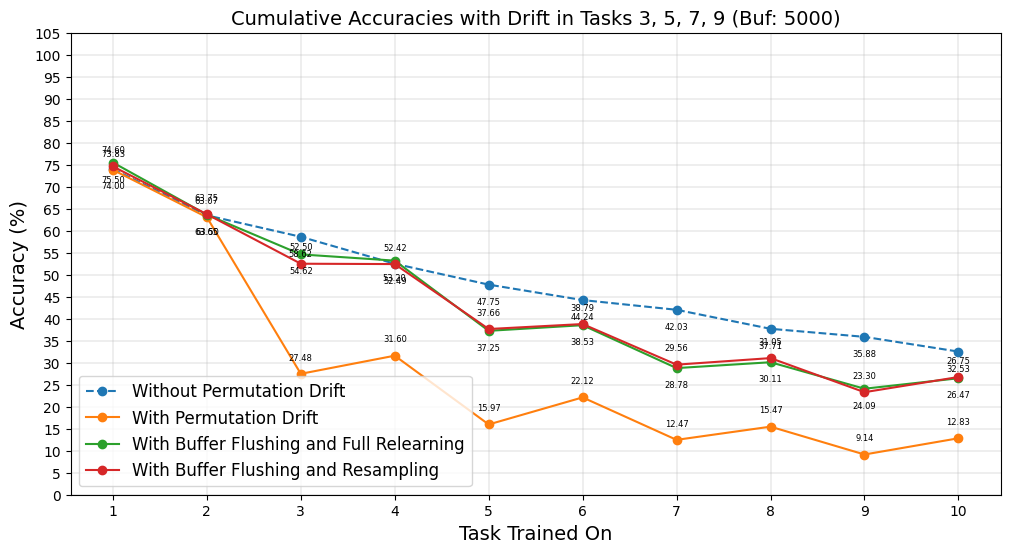

In [93]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

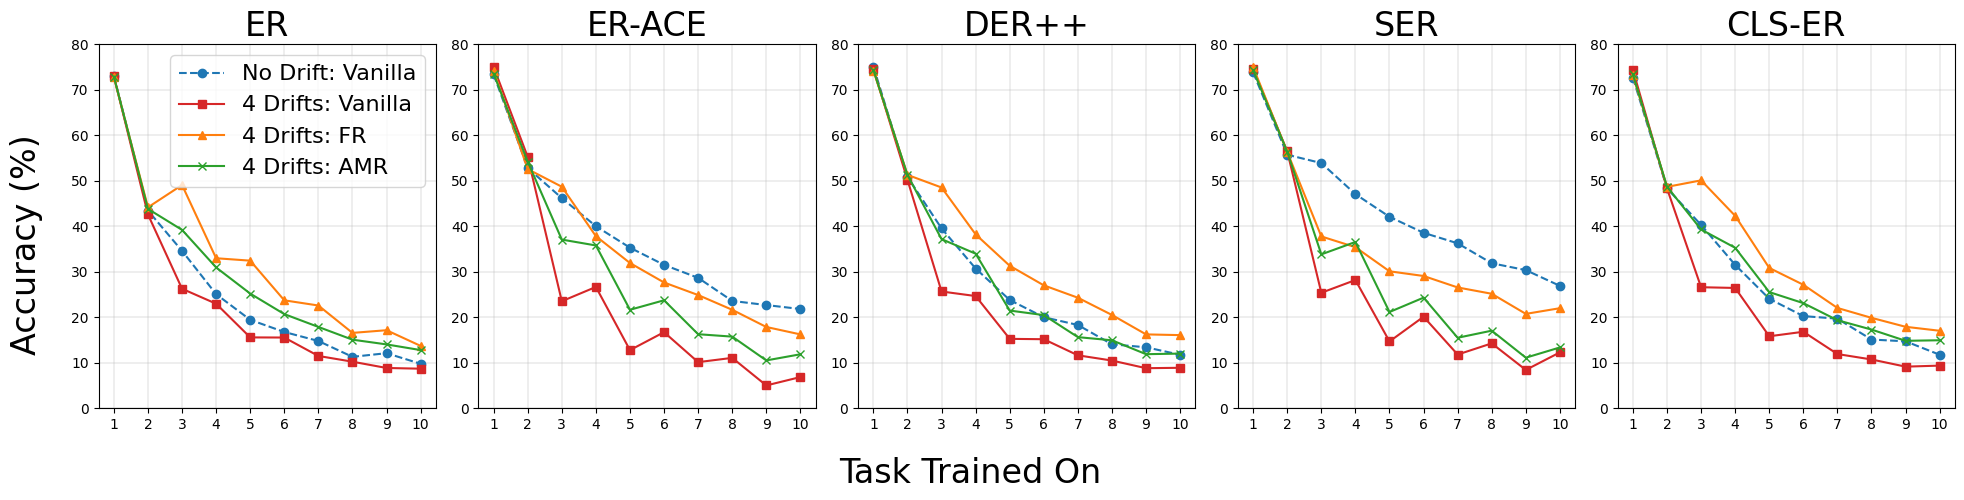

In [94]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "4 Drifts: Vanilla",
        "4 Drifts: FR",
        "4 Drifts: AMR",
    ],
    plot_filename="CIFAR100_Buff_500_n_4.pdf",
)

## Buffer 5000

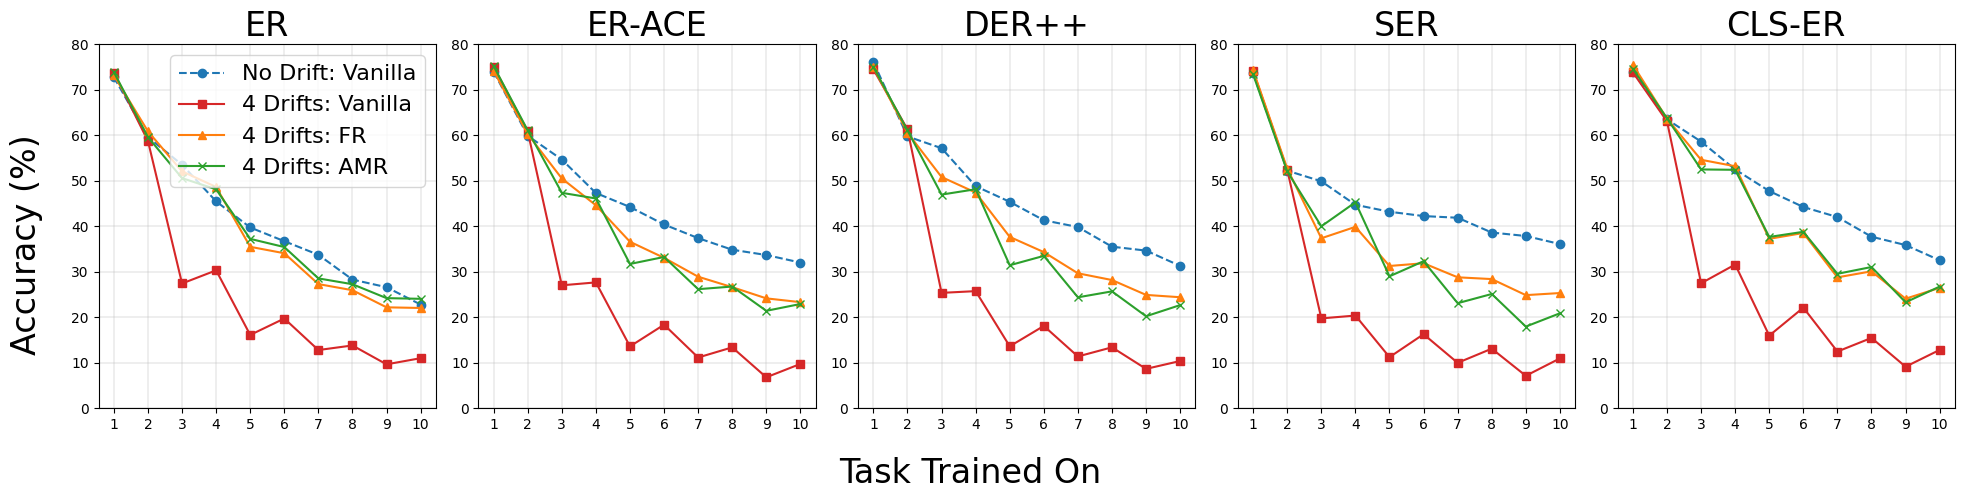

In [95]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "4 Drifts: Vanilla",
        "4 Drifts: FR",
        "4 Drifts: AMR",
    ],
    plot_filename="CIFAR100_Buff_5000_n_4.pdf",
)